****Importing Libraries****


In [1]:
import re
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
train=pd.read_csv("/kaggle/input/tweet-sentiment-extraction/train.csv")
test=pd.read_csv("/kaggle/input/tweet-sentiment-extraction/test.csv")

In [3]:
train.isnull().value_counts()

textID  text   selected_text  sentiment
False   False  False          False        27480
        True   True           False            1
dtype: int64

In [4]:
train.dropna(inplace=True)

In [5]:
temp=train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap="Blues")

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


In [6]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

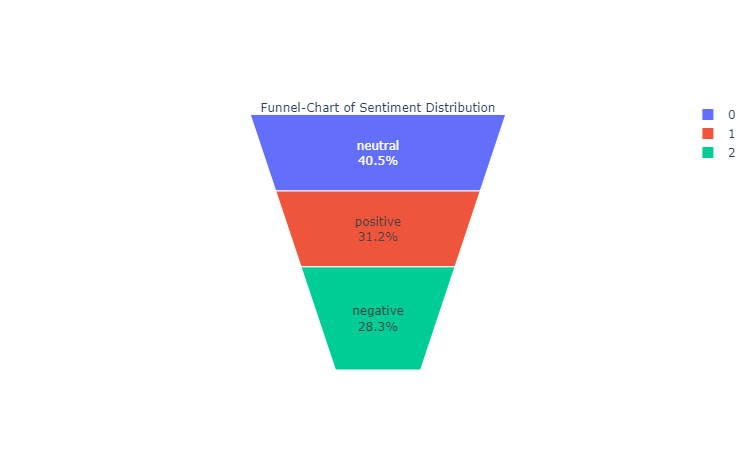

In [7]:
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

In [8]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [9]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [10]:
results_jaccard=[]

for ind,row in train.iterrows():
    sentence1 = row.text
    sentence2 = row.selected_text

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [11]:
jaccard = pd.DataFrame(results_jaccard,columns=["text","selected_text","jaccard_score"])
train = train.merge(jaccard,how='outer')

In [12]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286


In [13]:
train['Num_words_ST']=train['selected_text'].apply(lambda x:len(str(x).split()))
train['Num_words_Text']=train['text'].apply(lambda x:len(str(x).split()))
train['difference_in_words']=train['Num_words_Text']-train['Num_words_ST']

In [14]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_words_Text,difference_in_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286,3,14,11


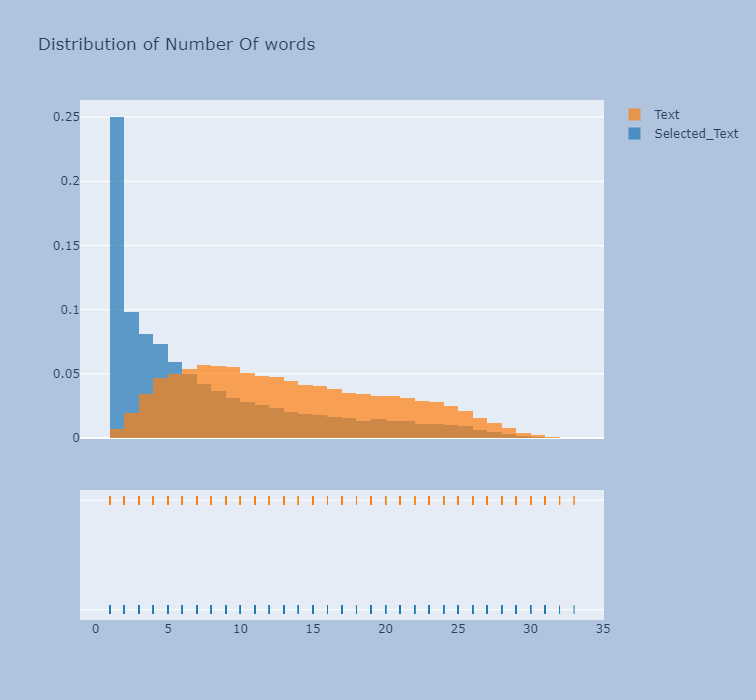

In [15]:
hist_data = [train['Num_words_ST'],train['Num_words_Text']]

group_labels = ['Selected_Text', 'Text']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,show_curve=False)
fig.update_layout(title_text='Distribution of Number Of words')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)
fig.show()

**See the difference in number of words for each sentiment using kdeplot**

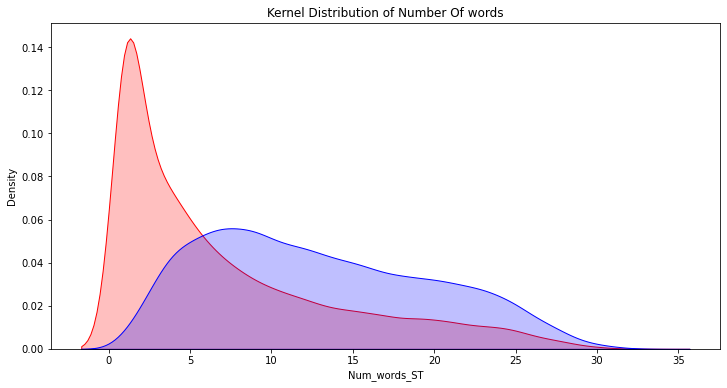

In [16]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train['Num_words_ST'], shade=True, color="r").set_title('Kernel Distribution of Number Of words')
p1=sns.kdeplot(train['Num_words_Text'], shade=True, color="b")

**In the above plot we can see the no of tweets with no of words greater than 25 are very less**

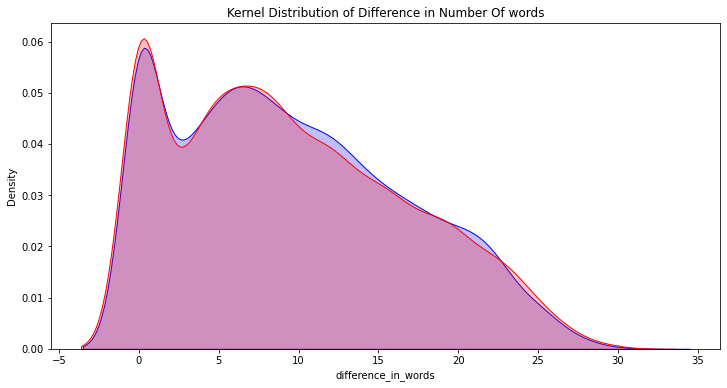

In [17]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['difference_in_words'], shade=True, color="b").set_title('Kernel Distribution of Difference in Number Of words')
p2=sns.kdeplot(train[train['sentiment']=='negative']['difference_in_words'], shade=True, color="r")


Text(0.5, 1.0, 'KDE of the jaccard scores across different sentiments')

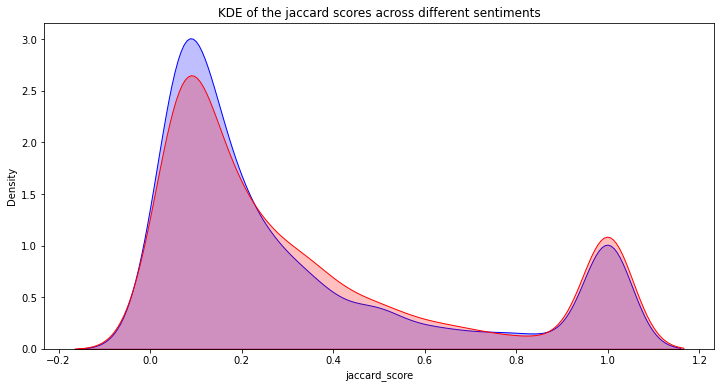

In [18]:
plt.figure(figsize=(12,6))
sns.kdeplot(train[train['sentiment']=='positive']['jaccard_score'],shade=True,color="b").set_title('KDE of the jaccard scores across different sentiments')
sns.kdeplot(train[train['sentiment']=='negative']['jaccard_score'],shade=True,color="r").set_title('KDE of the jaccard scores across different sentiments')

**SO THE CONCLUSION FROM THE EXPLORATORY DATA ANALYSIS IS THAT THE POSITIVE AND NEGATIVE TWEETS ARE SEEING A BUMP AROUND JACCARD SCORE OF 1.
SO WE SHOULD FOCUS ON FINDING THESE TWEETS HAVING JACCARD SCORE AROUND 1.**

In [19]:
k=train[train['Num_words_Text']<=2]
k.groupby('sentiment').mean()['jaccard_score']

sentiment
negative    0.788580
neutral     0.977805
positive    0.765700
Name: jaccard_score, dtype: float64

In [20]:
k[k['sentiment']=='positive']

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_words_Text,difference_in_words
68,fa2654e730,Chilliin,Chilliin,positive,1.0,1,1,0
80,bbbc46889b,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,positive,1.0,2,2,0
170,f3d95b57b1,good morning,good morning,positive,1.0,2,2,0
278,89d5b3f0b5,Thanks,Thanks,positive,1.0,1,1,0
429,a78ef3e0d0,Goodmorning,Goodmorning,positive,1.0,1,1,0
...,...,...,...,...,...,...,...,...
26689,e80c242d6a,Goodnight;,Goodnight;,positive,1.0,1,1,0
26725,aad244f37d,*hug*,*hug*,positive,1.0,1,1,0
26842,a46571fe12,congrats!,congrats!,positive,1.0,1,1,0
26959,49a942e9b1,Happy birthday.,Happy birthday.,positive,1.0,2,2,0


**WE WILL FIRST CLEAN THE TWEETS**

In [21]:
import string

In [22]:
def clean_tweet(text):
    text=str(text).lower()
    text = re.sub('\[.*?\]', '', text) #remove all the expression inside the square brackets
    text = re.sub('https?://\S+|www\.\S+', '', text)#remove the links
    text = re.sub('<.*?>+', '', text)#remove the expressions inside the angular brackets like XML and HTML tags
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)#remove the punctuation marks
    text = re.sub('\n', '', text)#remove the endline characters 
    text = re.sub('\w*\d\w*', '', text)#remove the words containing a digit atleast in between two words
    return text
    

In [23]:
train['text']=train['text'].apply(lambda x:clean_tweet(x))
train['selected_text']=train['selected_text'].apply(lambda x:clean_tweet(x))

In [24]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_words_Text,difference_in_words
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,1.000000,7,7,0
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative,0.214286,3,14,11


In [25]:
train['temp_list']=train['selected_text'].apply(lambda x:str(x).split())
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
train['temp_list'] = train['temp_list'].apply(lambda x:remove_stopword(x))


In [26]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_words_Text,difference_in_words,temp_list
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,1.000000,7,7,0,"[id, responded, going]"
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,0.200000,2,10,8,"[sooo, sad]"
2,088c60f138,my boss is bullying me,bullying me,negative,0.166667,2,5,3,[bullying]
3,9642c003ef,what interview leave me alone,leave me alone,negative,0.600000,3,5,2,"[leave, alone]"
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative,0.214286,3,14,11,[sons]


In [27]:
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,good,1251
2,day,1058
3,love,909
4,happy,852
5,like,774
6,get,772
7,dont,765
8,go,700
9,cant,613
10,work,612


In [28]:
train['temp_list1']=train['text'].apply(lambda x:str(x).split())
train['temp_list1'] = train['temp_list1'].apply(lambda x:remove_stopword(x)) #Removing Stopwords(x))

In [29]:
top = Counter([item for sublist in train['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
1,day,2044
2,good,1549
3,get,1426
4,like,1346
5,go,1267
6,dont,1200
7,love,1122
8,work,1112
9,going,1096
10,today,1096


**Classifying the most common words sentiment wise:**

In [30]:
positive_sent=train[train['sentiment']=='positive']
negative_sent=train[train['sentiment']=='negative']
neutral_sent=train[train['sentiment']=='neutral']

In [31]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_words_Text,difference_in_words,temp_list,temp_list1
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,1.000000,7,7,0,"[id, responded, going]","[id, responded, going]"
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,0.200000,2,10,8,"[sooo, sad]","[sooo, sad, miss, san, diego]"
2,088c60f138,my boss is bullying me,bullying me,negative,0.166667,2,5,3,[bullying],"[boss, bullying]"
3,9642c003ef,what interview leave me alone,leave me alone,negative,0.600000,3,5,2,"[leave, alone]","[interview, leave, alone]"
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative,0.214286,3,14,11,[sons],"[sons, couldnt, put, releases, already, bought]"


In [32]:
top = Counter([item for sublist in positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,good,826
1,happy,730
2,love,697
3,day,456
4,thanks,439
5,great,364
6,fun,287
7,nice,267
8,mothers,259
9,hope,245


In [33]:
top = Counter([item for sublist in negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Greens')

,Common_words,count
1,miss,358
2,sad,343
3,sorry,300
4,bad,246
5,hate,230
6,dont,221
7,cant,201
8,sick,166
9,like,162
10,sucks,159


In [34]:
top = Counter([item for sublist in neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.iloc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Greens')

,Common_words,count
1,get,612
2,go,569
3,day,492
4,dont,482
5,going,472
6,work,467
7,like,445
8,got,441
9,today,427
10,lol,427


In [35]:
raw_text=[word for word_list in train['temp_list1'] for word in word_list]

**FUNCTION FOR UNIQUE WORDS**

In [36]:
def words_unique(sentiment,numwords,raw_words):
    '''
    Input:
        segment - Segment category (ex. 'Neutral');
        numwords - how many specific words do you want to see in the final result; 
        raw_words - list  for item in train_data[train_data.segments == segments]['temp_list1']:
    Output: 
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    allother = []
    for item in train[train.sentiment != sentiment]['temp_list1']:#for those sentiments where the sentiment is not equal to the given one
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))  #set is used here because we want the list to contain non duplicate values
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in train[train.sentiment == sentiment]['temp_list1']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words

**FOR THE POSITIVE SENTIMENT ONES**

In [37]:
Unique_positive=words_unique('positive',25,raw_text)


In [38]:
print("The top 25 unique words in the Positive Tweets are: ")
Unique_positive.style.background_gradient(cmap='Greens')

The top 25 unique words in the Positive Tweets are: 


,words,count
0,congratulations,29
1,thnx,10
2,appreciated,8
3,shared,7
4,presents,7
5,greetings,7
6,blessings,6
7,mothersday,6
8,mcr,6
9,coolest,6


**Treemap for unique positive words**

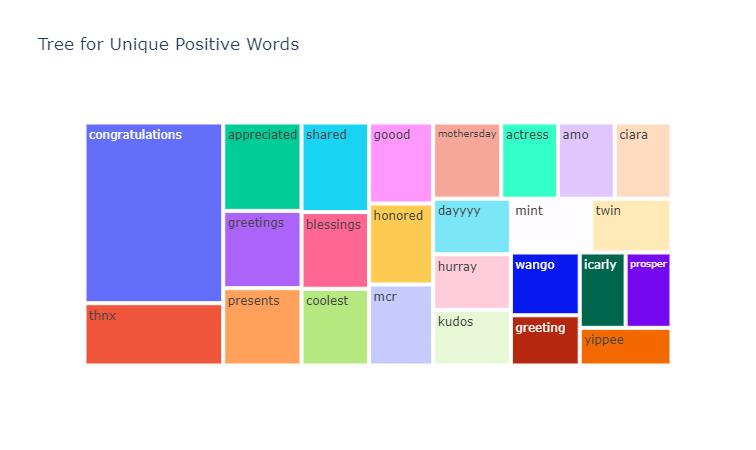

In [39]:
fig = px.treemap(Unique_positive, path=['words'], values='count',title='Tree for Unique Positive Words')
fig.show()

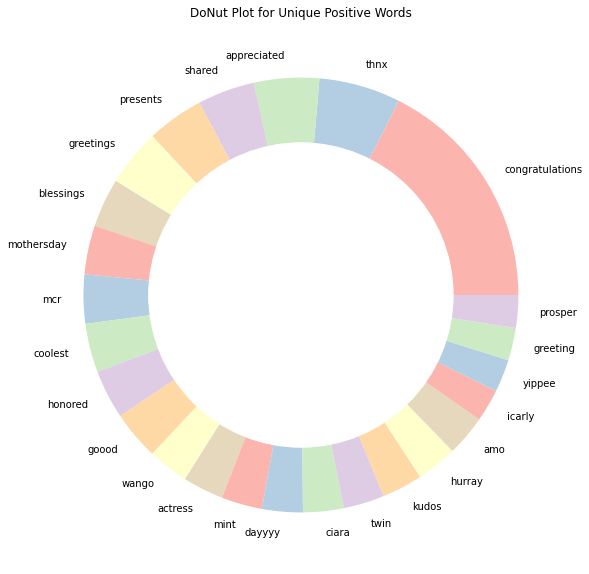

In [40]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_positive['count'], labels=Unique_positive.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot for Unique Positive Words')
plt.show()

In [41]:
Unique_negative=words_unique('negative',25,raw_text)
print("The 25 unique negative words are:")
Unique_negative.style.background_gradient(cmap='Blues')

The 25 unique negative words are:


,words,count
0,ache,12
1,suffering,9
2,allergic,7
3,cramps,7
4,saddest,7
5,pissing,7
6,sob,6
7,dealing,6
8,devastated,6
9,noes,6


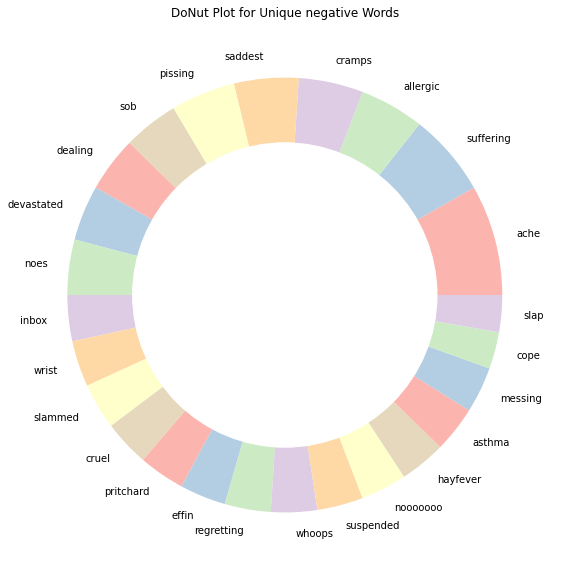

In [42]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_negative['count'], labels=Unique_negative.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot for Unique negative Words')
plt.show()

In [43]:
Unique_Neutral= words_unique('neutral', 25, raw_text)
print("The top 10 unique words in Neutral Tweets are:")
Unique_Neutral.style.background_gradient(cmap='Oranges')

The top 10 unique words in Neutral Tweets are:


,words,count
0,settings,9
1,explain,7
2,mite,6
3,hiya,6
4,reader,5
5,pr,5
6,sorta,5
7,fathers,5
8,enterprise,5
9,guessed,5


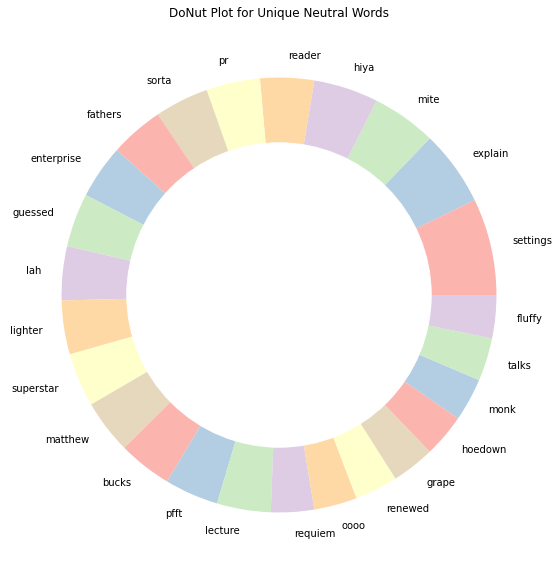

In [44]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Neutral['count'], labels=Unique_Neutral.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot for Unique Neutral Words')
plt.show()

**MODELLING**

In [45]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_words_Text,difference_in_words,temp_list,temp_list1
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,1.000000,7,7,0,"[id, responded, going]","[id, responded, going]"
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,0.200000,2,10,8,"[sooo, sad]","[sooo, sad, miss, san, diego]"
2,088c60f138,my boss is bullying me,bullying me,negative,0.166667,2,5,3,[bullying],"[boss, bullying]"
3,9642c003ef,what interview leave me alone,leave me alone,negative,0.600000,3,5,2,"[leave, alone]","[interview, leave, alone]"
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative,0.214286,3,14,11,[sons],"[sons, couldnt, put, releases, already, bought]"


In [46]:
train_df = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
test_df = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')
submission_df = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/sample_submission.csv')

**WE ARE TAKING THE NUM WORDS TEXT GREATER THAN 3 DIRECTLY BECAUSE THEY CAN BE TAKEN DIRECTLY WITHOUT ANY PREPROCESSING**

In [47]:
train_df['Num_words_text'] = train_df['text'].apply(lambda x:len(str(x).split())) #Number Of words in main Text in train set
train_df = train_df[train_df['Num_words_text']>=3]

**USING SPACY MODEL**

In [48]:
from spacy.training.example import Example

In [49]:
#dropping null values rows

train_df = train_df.dropna()

In [50]:
def save_model(output_dir, nlp, new_model_name):
    output_dir = f'../working/{output_dir}'
    
    if output_dir is not None:        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        nlp.meta["name"] = new_model_name
        nlp.to_disk(output_dir)
        print("Saved a model to --", output_dir)

In [51]:
# defining train

def train(train_data, output_dir, n_iter=20, model=None):
    """Load the model, set up the pipeline and train the entity recognizer."""
    ""
    if model is not None:
        nlp = spacy.load(output_dir)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")
    
    # create the built-in pipeline components and add them to the pipeline
    
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe('ner', last = True)
        
    # otherwise, get it so we can have labels added
    
    else:
        ner = nlp.get_pipe("ner")
    
    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  # only train NER
        
        if model is None:
            nlp.begin_training()
        else:
            nlp.resume_training()

    for itr in tqdm( range(n_iter)): 
        
        losses = {}
        
        for batch in spacy.util.minibatch(train_data, size = 2):
            for text, annotations in batch:
                # create Example
                doc = nlp.make_doc(text)
                example = Example.from_dict(doc, annotations)
                # Updating the model
                nlp.update([example], losses = losses, drop = 0.3)

        print("Losses", losses)
        
    save_model(output_dir, nlp, 'st_ner')

In [52]:
def get_model_out_path(sentiment):
    model_out_path = None
    if sentiment == 'positive':
        model_out_path = 'kaggle/input/tse-spacy-model/models/model_pos'
    elif sentiment == 'negative':
        model_out_path = 'kaggle/input/tse-spacy-model/models/model_neg'
    else:
        model_out_path = 'kaggle/input/tse-spacy-model/models/model_neu'
    return model_out_path

In [53]:
#creating data in spacy data input format

def get_training_data(sentiment):
    train_data = []
    for index, row in train_df.iterrows():
        #for each sentiment
        if row.sentiment == sentiment:
            selected_text = row.selected_text
            text = row.text
            start = text.find(selected_text)
            end = start + len(selected_text)
            train_data.append((text, {"entities": [[start, end, 'selected_text']]}))
            
    return train_data

In [54]:
#positive sentiment
sentiment = 'positive'

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)

# training for 3 iterations
train(train_data, model_path, n_iter = 3, model = None)

[2023-02-05 20:08:58,375] [INFO] Created vocabulary
[2023-02-05 20:08:58,378] [INFO] Finished initializing nlp object


Created blank 'en' model


 33%|███▎      | 1/3 [03:24<06:48, 204.35s/it]

Losses {'ner': 12933.24741558408}


 67%|██████▋   | 2/3 [06:57<03:29, 209.43s/it]

Losses {'ner': 12284.260074964634}


100%|██████████| 3/3 [10:33<00:00, 211.09s/it]

Losses {'ner': 12466.816405138181}
Saved a model to -- ../working/kaggle/input/tse-spacy-model/models/model_pos


In [55]:
#negative sentiment
sentiment = 'negative'

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)

# training model for 3 iterations
train(train_data, model_path, n_iter = 3, model = None)

[2023-02-05 20:19:33,737] [INFO] Created vocabulary
[2023-02-05 20:19:33,739] [INFO] Finished initializing nlp object


Created blank 'en' model


 33%|███▎      | 1/3 [03:07<06:14, 187.34s/it]

Losses {'ner': 12403.66405030437}


 67%|██████▋   | 2/3 [06:22<03:11, 191.65s/it]

Losses {'ner': 11781.049891209197}


100%|██████████| 3/3 [09:37<00:00, 192.40s/it]

Losses {'ner': 11582.20741106612}
Saved a model to -- ../working/kaggle/input/tse-spacy-model/models/model_neg


In [56]:
#neutral sentiment
sentiment = 'neutral'

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)

# training model for 3 iterations
train(train_data, model_path, n_iter = 3, model = None)


[2023-02-05 20:29:13,067] [INFO] Created vocabulary
[2023-02-05 20:29:13,069] [INFO] Finished initializing nlp object


Created blank 'en' model


 33%|███▎      | 1/3 [04:18<08:36, 258.07s/it]

Losses {'ner': 4389.3211526034665}


 67%|██████▋   | 2/3 [08:47<04:24, 264.48s/it]

Losses {'ner': 3563.8592902300193}


100%|██████████| 3/3 [13:20<00:00, 266.90s/it]

Losses {'ner': 3246.741462541903}
Saved a model to -- ../working/kaggle/input/tse-spacy-model/models/model_neu


In [57]:
train_df

,textID,text,selected_text,sentiment,Num_words_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,10
2,088c60f138,my boss is bullying me...,bullying me,negative,5
3,9642c003ef,what interview! leave me alone,leave me alone,negative,5
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,14
...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,16
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,23
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,22
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,6


In [58]:
trained_models_path = 'kaggle/input/tse-spacy-model/models/'

In [59]:
def predict_entities(text, model):
    doc = model(text)
    ent_array = []
    for ent in doc.ents:
        start = text.find(ent.text)
        end = start + len(ent.text)
        new_int = [start, end, ent.label_]
        if new_int not in ent_array:
            ent_array.append([start, end, ent.label_])
    selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
    return selected_text

In [60]:
def jaccard(str1, str2): 
    doc1 = set(str1.lower().split()) 
    doc2 = set(str2.lower().split())
    c = doc1.intersection(doc2)
    return float(len(c)) / (len(doc1) + len(doc2) - len(c))


if trained_models_path is not None:
    print("Loading the models  from ", trained_models_path)
    model_pos = spacy.load(trained_models_path + 'model_pos')
    model_neg = spacy.load(trained_models_path + 'model_neg')
    model_neu = spacy.load(trained_models_path + 'model_neu')
        
    jaccard_score = 0
    for index, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):
        text = row.text
        if row.sentiment == 'neutral':
            jaccard_score += jaccard(predict_entities(text, model_neu), row.selected_text)
        elif row.sentiment == 'positive':
            jaccard_score += jaccard(predict_entities(text, model_pos), row.selected_text)
        else:
            jaccard_score += jaccard(predict_entities(text, model_neg), row.selected_text) 
        
    print(f'The average Jaccard Score is : {jaccard_score / train_df.shape[0]}')

Loading the models  from  kaggle/input/tse-spacy-model/models/


100%|██████████| 26752/26752 [01:38<00:00, 272.04it/s]

The average Jaccard Score is : 0.5954529340578163


In [61]:
#paths
BASE_PATH = '../input/tweet-sentiment-extraction/'
MODELS_BASE_PATH = 'kaggle/input/tse-spacy-model/models/'
MODELS_BASE_PATH2 = 'kaggle/input/tse-spacy-model/models/'

test_df = pd.read_csv( BASE_PATH + 'test.csv')
submission_df = pd.read_csv( BASE_PATH + 'sample_submission.csv')

In [62]:
def predict_entities(text, model):
    doc = model(text)
    ent_array = []
    for ent in doc.ents:
        start = text.find(ent.text)
        end = start + len(ent.text)
        new_int = [start, end, ent.label_]
        if new_int not in ent_array:
            ent_array.append([start, end, ent.label_])
    selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
    return selected_text

In [63]:
selected_texts = []

if MODELS_BASE_PATH is not None:
    
    print("Loading Models  from ", MODELS_BASE_PATH)
    model_pos = spacy.load(MODELS_BASE_PATH + 'model_pos')
    model_neg = spacy.load(MODELS_BASE_PATH2 + 'model_neg')
    model_neu = spacy.load(MODELS_BASE_PATH + 'model_neu')
        
    for index, row in test_df.iterrows():
        text = row.text
        output_str = ""
        if row.sentiment == 'neutral' or len(text.split()) < 4:
            selected_texts.append(text)
        elif row.sentiment == 'positive':
            selected_texts.append(predict_entities(text, model_pos))
        else:
            selected_texts.append(predict_entities(text, model_neg))
        
test_df['selected_text'] = selected_texts

Loading Models  from  kaggle/input/tse-spacy-model/models/


In [64]:
test_df['selected_text']

0       Last session of the day  http://twitpic.com/67ezh
1                                                    Good
2                                           Recession hit
3                                             happy bday!
4                  http://twitpic.com/4w75p - I like it!!
                              ...                        
3529                                             its at 3
3530                                               Thanks
3531     I know what you mean. My little dog is sinkin...
3532                                  I love your videos!
3533     http://twitpic.com/4woj2 - omgssh  ang cute n...
Name: selected_text, Length: 3534, dtype: object

In [65]:
submission_df['selected_text'] = test_df['selected_text']
submission_df.to_csv("submission.csv", index = False)

In [66]:
display(submission_df.head(15))

,textID,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,Good
2,eee518ae67,Recession hit
3,01082688c6,happy bday!
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!
5,726e501993,that`s great!
6,261932614e,I THINK EVERYONE
7,afa11da83f,"soooooo wish i could, but im in school and my..."
8,e64208b4ef,and within a short time of the last clue all ...
9,37bcad24ca,What did you get? My day is alright.. haven`...


**BERT Modelling**

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import transformers
import tokenizers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

In [68]:
class config:
    FOLDS=5
    MAX_LEN=128
    TRAIN_BATCH_SIZE=64
    VALID_BATCH_SIZE=16
    EPOCHS=5
    BERT_PATH="/kaggle/input/bert-base-uncased"
    ROBERTA_PATH="/kaggle/input/roberta-base"
    TRAINING_FILE="../input/tweet-train-folds/train_folds.csv"
    TOKENIZER = tokenizers.BertWordPieceTokenizer(
        f"{BERT_PATH}/vocab.txt", 
        lowercase=True
    ) 
    Rb_TOKENIZER=tokenizers.ByteLevelBPETokenizer( 
    f"{ROBERTA_PATH}/vocab.json", 
    f"{ROBERTA_PATH}/merges.txt", 
    lowercase=True,
    add_prefix_space=True
)

In [69]:
def process_bert_data(tweet, selected_text, sentiment, tokenizer, max_len):
    len_st = len(selected_text)
    idx0 = None
    idx1 = None
    
    # Getting the start and end indices of the selected_text in tweet 
    for ind in (i for i, e in enumerate(tweet) if e == selected_text[0]):
        if tweet[ind: ind+len_st] == selected_text:
            idx0 = ind
            idx1 = ind + len_st - 1
            break
    
    # Creating a list of 0's same length as tweet 
    # then filling all the indices where tweet == selected_text with 1's 
    # ex - char_targets before = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    char_targets = [0] * len(tweet)
    if idx0 != None and idx1 != None:
        for ct in range(idx0, idx1 + 1):
            char_targets[ct] = 1
    # char_targets after = [0,0,0,0,0,1,1,1,1,1,1,0,0,0,0]  at character level not word level
    
    # tokenizing each tweet
    tok_tweet = tokenizer.encode(tweet)
    input_ids_orig = tok_tweet.ids[1:-1]  #not considering cls and sep token
    tweet_offsets = tok_tweet.offsets[1:-1] #shape[(1,5)] [(token's starting index,endingindex)]

    # we recieved a list of token offets
    # Now we want a list of indices of the words where tweet == selected_text   
    target_idx = []
    for j, (offset1, offset2) in enumerate(tweet_offsets):
        if sum(char_targets[offset1: offset2]) > 0:
            target_idx.append(j)
    
    # getting the starting and ending indices where tweet == selected_text 
    targets_start = target_idx[0]
    targets_end = target_idx[-1]

    sentiment_id = {
        'positive': 3893,
        'negative': 4997,
        'neutral': 8699
    }
    
    # adding 3 more tokens at the start
    input_ids = [101] + [sentiment_id[sentiment]] + [102] + input_ids_orig + [102]
    token_type_ids = [0, 0, 0] + [1] * (len(input_ids_orig) + 1)
    mask = [1] * len(token_type_ids)
    tweet_offsets = [(0, 0)] * 3 + tweet_offsets + [(0, 0)]
    targets_start += 3 # adding 3 more indices to the target_start
    targets_end += 3   # adding 3 more indices to the target_end

    # if max length>length of input_id then add pading to input_ids,mask,token_type_ids,tweet_offset
    padding_length = max_len - len(input_ids)
    if padding_length > 0:
        input_ids = input_ids + ([0] * padding_length)
        mask = mask + ([0] * padding_length)
        token_type_ids = token_type_ids + ([0] * padding_length)
        tweet_offsets = tweet_offsets + ([(0, 0)] * padding_length)
    
    # So as a whole we will be returning input_ids,mask,toke_type_ids,targets_start,targets_end
    #original tweet ,original selected text , sentiment , tweet offsets
    return {
        'ids': input_ids, # input_ids=[101]+[sentiment_id[sentiment]]+[102]+input_ids_orig+[102]
        'mask': mask, # [1] * len(token_type_ids)
        'token_type_ids': token_type_ids, # [0, 0, 0] + [1] * (len(input_ids_orig) + 1)
        'offsets': tweet_offsets, # [(0, 0)] * 3 + tweet_offsets + [(0, 0)]
        'targets_start': targets_start, # targets_start = target_idx[0] + 3
        'targets_end': targets_end, # targets_end = target_idx[-1] + 3
        'orig_tweet': tweet, 
        'orig_selected': selected_text,
        'sentiment': sentiment}

In [70]:
class BertDataset:
    def __init__(self, tweet, sentiment, selected_text):
        self.tweet = tweet
        self.sentiment = sentiment
        self.selected_text = selected_text
        self.tokenizer = config.TOKENIZER
        self.max_len = config.MAX_LEN
    
    def __len__(self):
        return len(self.tweet)

    def __getitem__(self, item):
        data = process_bert_data(
            self.tweet[item], 
            self.selected_text[item], 
            self.sentiment[item],
            self.tokenizer,
            self.max_len
        )
       
    # Return the processed data where the lists are converted to `torch.tensor`s
        return {
            'ids': torch.tensor(data["ids"], dtype=torch.long),
            'mask': torch.tensor(data["mask"], dtype=torch.long),
            'token_type_ids': torch.tensor(data["token_type_ids"], dtype=torch.long),
            'offsets': torch.tensor(data["offsets"], dtype=torch.long),
            'targets_start': torch.tensor(data["targets_start"], dtype=torch.long),
            'targets_end': torch.tensor(data["targets_end"], dtype=torch.long),
            'orig_tweet': data["orig_tweet"],
            'orig_selected': data["orig_selected"],
            'sentiment': data["sentiment"]
        }

In [71]:
class BertModel(transformers.BertPreTrainedModel):
    """
    Model class that combines a pretrained bert model with a linear later
    """
    def __init__(self, conf):
        super(BertModel, self).__init__(conf)
        # Load the pretrained BERT model
        self.bert = transformers.BertModel.from_pretrained(config.BERT_PATH, config=conf)
        
        # Set 10% dropout to be applied to the BERT backbone's output
        self.drop_out = nn.Dropout(0.1)
        
        # 768 is the dimensionality of bert-base's hidden representations
        # Multiplied by 2 since the forward pass concatenates last two hidden representation layers
        # The output will have two dimensions ("start_logits", and "end_logits")
        self.l0 = nn.Linear(768, 2)
        
        torch.nn.init.normal_(self.l0.weight, std=0.02)
        torch.nn.init.normal_(self.l0.bias,0)
    
    def forward(self, ids, mask, token_type_ids):
        # seqeunce_ouput , pooled_output , outputs_hidden_state  
        outputs = self.bert(
            ids,
            attention_mask=mask,
            token_type_ids=token_type_ids
        )
        #batch_size(bs) x Sequence_Length(SL) x Embedding(768X2) [(batch_size,num_tokens,768X2)]
        
        # Concatenate the last two hidden states
        # This is done since experiments have shown that just getting the last layer
        # gives out vectors that may be too taylored to the orig BERT training objectives(MLM + NSP)
        
        out = torch.stack((outputs.hidden_states[-1], outputs.hidden_states[-2], 
                         outputs.hidden_states[-3], outputs.hidden_states[-4])) 
        out = torch.mean(out, 0)
        # bs x SL x (768)
        
        # Apply 10% dropout to the last 2 hidden states
        out = self.drop_out(out)  # bs x SL x (768)
        
        # The "dropped out" hidden vectors are now fed into the linear layer to output two scores
        logits = self.l0(out) # bs x SL x 2

        # Splits the tensor into start_logits and end_logits
        # (bs x SL x 2) -> (bs x SL x 1), (bs x SL x 1)
        start_logits, end_logits = logits.split(1, dim=-1)

        start_logits = start_logits.squeeze(-1) # (bs x SL)
        end_logits = end_logits.squeeze(-1) # (bs x SL)

        return start_logits, end_logits

In [72]:
def loss_fn(start_logits, end_logits, start_positions, end_positions):
    """
    Return the sum of the cross entropy losses for both the start and end logits
    """
    loss_fct = nn.CrossEntropyLoss()
    start_loss = loss_fct(start_logits, start_positions)
    end_loss = loss_fct(end_logits, end_positions)
    total_loss = (start_loss + end_loss)
    return total_loss

In [73]:
def calculate_jaccard_score(
    original_tweet, 
    target_string, 
    sentiment_val, 
    idx_start, 
    idx_end, 
    offsets,
    verbose=False):
    
    """
    Calculate the jaccard score from the predicted span and the actual span for a batch of tweets
    """
    
    # A span's start index has to be less than or equal to the end index
    # If this doesn't hold, the end index is set to equal the start index (span is a single token)
    if idx_end < idx_start:
        idx_end = idx_start
    
    filtered_output  = ""
    for ix in range(idx_start, idx_end + 1):
        filtered_output += original_tweet[offsets[ix][0]: offsets[ix][1]]
        # If the token is not last token in the tweet, and ending offset of current token is less
         # than the beginning offset of the following token, add a space.
        # Basically, add a space when the next token (word piece) corresponds to a new word
        if (ix+1) < len(offsets) and offsets[ix][1] < offsets[ix+1][0]:
            filtered_output += " "
   
    # Set the predicted output as the original tweet when the tweet's sentiment is "neutral", 
    # or the tweet's len is less than or equal to 4
    if sentiment_val == "neutral" or len(original_tweet) <= 4: 
        filtered_output = original_tweet
    
    # Calculate the jaccard score between the predicted span, and the actual span
    # The IOU (intersection over union) approach is detailed in the utils module's `jaccard` function:
    # https://www.kaggle.com/abhishek/utils
    jac = utils.jaccard(target_string.strip(), filtered_output.strip())
    return jac, filtered_output

def train_fn(data_loader, model, optimizer, device, scheduler=None):
    """
    Trains the bert model on the twitter data
    """
    # Set model to training mode (dropout + sampled batch norm is activated)
    model.train()
    losses = utils.AverageMeter()
    jaccards = utils.AverageMeter()

    # Set tqdm to add loading screen and set the length
    tk0 = tqdm(data_loader, total=len(data_loader))
    
    for bi, d in enumerate(tk0):

        ids = d["ids"]
        token_type_ids = d["token_type_ids"]
        mask = d["mask"]
        offsets = d["offsets"]
        targets_start = d["targets_start"]
        targets_end = d["targets_end"]
        sentiment = d["sentiment"]
        orig_selected = d["orig_selected"]
        orig_tweet = d["orig_tweet"]
        
        # Move ids, masks, and targets to gpu while setting as torch.long
        ids = ids.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets_start = targets_start.to(device, dtype=torch.long)
        targets_end = targets_end.to(device, dtype=torch.long)

        # Reset gradients
        model.zero_grad()
        
        # Use ids, masks, and token types as input to the model
        # Predict logits for each of the input tokens for each batch
        outputs_start, outputs_end = model(
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids
        )# (bs x SL), (bs x SL)
        
        # Calculate batch loss based on CrossEntropy
        loss = loss_fn(outputs_start, outputs_end, targets_start, targets_end)
        # Calculate gradients based on loss
        loss.backward()
        # Adjust weights based on calculated gradients
        optimizer.step()
        # Update scheduler
        if scheduler is not None: scheduler.step()
        
        # Apply softmax to the start and end logits
        # This squeezes each of the logits in a sequence to a value between 0 and 1, 
        # while ensuring that they sum to 1
        # This is similar to the characteristics of "probabilities"
        outputs_start = torch.softmax(outputs_start, dim=1).cpu().detach().numpy()
        outputs_end = torch.softmax(outputs_end, dim=1).cpu().detach().numpy()
        
        # Calculate the jaccard score based on the predictions for this batch
        jaccard_scores = []
        for px, tweet in enumerate(orig_tweet):
            selected_tweet = orig_selected[px] 
            tweet_sentiment = sentiment[px]
            jaccard_score, _ = calculate_jaccard_score(
                original_tweet=tweet, # Full text of the px'th tweet in the batch
                target_string=selected_tweet,# Span containing the specified sentiment for tweet
                sentiment_val=tweet_sentiment, # Sentiment of the px'th tweet in the batch
                idx_start=np.argmax(outputs_start[px, :]), # Predicted start index for px'th tweet 
                idx_end=np.argmax(outputs_end[px, :]),# Predicted end index for px'th tweet in batch
                offsets=offsets[px] # Offsets for each of the tokens for px'th tweet in the batch
            )
            jaccard_scores.append(jaccard_score)
        # Update the jaccard score and loss
        # For details, refer to `AverageMeter` in https://www.kaggle.com/abhishek/utils
        jaccards.update(np.mean(jaccard_scores), ids.size(0))
        losses.update(loss.item(), ids.size(0))
        # Print the average loss and jaccard score at the end of each batch
        tk0.set_postfix(loss=losses.avg, jaccard=jaccards.avg)


In [74]:
def eval_fn(data_loader, model, device):
    """
    Evaluation function to predict on the test set
    """
    # Set model to evaluation mode
    # I.e., turn off dropout and set batchnorm to use overall mean and variance (from training), 
    #rather than batch level mean and variance
    model.eval()
    losses = utils.AverageMeter()
    jaccards = utils.AverageMeter()
    
    # Turns off gradient calculations 
#(https://datascience.stackexchange.com/questions/32651/what-is-the-use-of-torch-no-grad-in-pytorch)
    with torch.no_grad():
        tk0 = tqdm(data_loader, total=len(data_loader))
        # Make predictions and calculate loss / jaccard score for each batch
        for bi, d in enumerate(tk0):
            ids = d["ids"]
            token_type_ids = d["token_type_ids"]
            mask = d["mask"]
            sentiment = d["sentiment"]
            orig_selected = d["orig_selected"]
            orig_tweet = d["orig_tweet"]
            targets_start = d["targets_start"]
            targets_end = d["targets_end"]
            offsets = d["offsets"].numpy()
            # Move ids, masks, and targets to gpu while setting as torch.long
            ids = ids.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            targets_start = targets_start.to(device, dtype=torch.long)
            targets_end = targets_end.to(device, dtype=torch.long)

            # Predict logits for start and end indexes
            outputs_start, outputs_end = model(
                ids=ids,
                mask=mask,
                token_type_ids= token_type_ids
            )
            
            # Calculate loss for the batch
            loss = loss_fn(outputs_start, outputs_end, targets_start, targets_end)
            # Apply softmax to the predicted logits for the start and end indexes
            # This converts the "logits" to "probability-like" scores
            outputs_start = torch.softmax(outputs_start, dim=1).cpu().detach().numpy()
            outputs_end = torch.softmax(outputs_end, dim=1).cpu().detach().numpy()
            # Calculate jaccard scores for each tweet in the batch
            jaccard_scores = []
            for px, tweet in enumerate(orig_tweet):
                selected_tweet = orig_selected[px]
                tweet_sentiment = sentiment[px]
                jaccard_score, _ = calculate_jaccard_score(
                    original_tweet=tweet,
                    target_string=selected_tweet,
                    sentiment_val=tweet_sentiment,
                    idx_start=np.argmax(outputs_start[px, :]),
                    idx_end=np.argmax(outputs_end[px, :]),
                    offsets=offsets[px]
                )
                jaccard_scores.append(jaccard_score)
                # Update running jaccard score and loss
            jaccards.update(np.mean(jaccard_scores), ids.size(0))
            losses.update(loss.item(), ids.size(0))
            # Print the running average loss and jaccard score
            tk0.set_postfix(loss=losses.avg, jaccard=jaccards.avg)
    
    print(f"Jaccard = {jaccards.avg}")
    return jaccards.avg

In [75]:
def run_bert():
    avg_jaccard=0
    total_jaccard=0
    for fold in range(config.FOLDS):
        # Read training csv
        dfx = pd.read_csv(config.TRAINING_FILE)

        # Set train validation set split
        df_train = dfx[dfx.kfold != fold].reset_index(drop=True)
        df_valid = dfx[dfx.kfold == fold].reset_index(drop=True)
    
        # Instantiate BertDataset with training data
        train_dataset = BertDataset(
        tweet=df_train.text.values,
        sentiment=df_train.sentiment.values,
        selected_text=df_train.selected_text.values
        )

        # Instantiate DataLoader with `train_dataset`
        # This is a generator that yields the dataset in batches
        train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.TRAIN_BATCH_SIZE,
        num_workers=4
        )
 
        # Instantiate BertDataset with validation data
        valid_dataset = BertDataset(
        tweet=df_valid.text.values,
        sentiment=df_valid.sentiment.values,
        selected_text=df_valid.selected_text.values
        )

        # Instantiate DataLoader with `valid_dataset`
        valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=config.VALID_BATCH_SIZE,
        num_workers=2
        )

       # Set device as `cuda` (GPU)
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
       # load pretrained Bert model 
        bert_config = transformers.BertConfig.from_pretrained(config.BERT_PATH)
       # Output hidden states
       # This is important to set since we want to concatenate the hidden states from the last 2 BERT layers
        bert_config.output_hidden_states = True
       # Instantiate our model with `model_config`
        bert_model = BertModel(conf=bert_config)
       # Move the model to the GPU if cuda available else cpu
        bert_model.to(device)

       # Calculate the number of training steps
        num_train_steps = int(len(df_train) / config.TRAIN_BATCH_SIZE * config.EPOCHS)
       # Get the list of named parameters
        param_optimizer = list(bert_model.named_parameters())
       # Specify parameters where weight decay shouldn't be applied
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
       # Define two sets of parameters: those with weight decay, and those without
        optimizer_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
       ]
    
       # Instantiate AdamW optimizer with our two sets of parameters, and a learning rate of 3e-5
        optimizer = AdamW(optimizer_parameters, lr=3e-5)
       # Create a scheduler to set the learning rate at each training step
       # "Create a schedule with a learning rate that decreases linearly after linearly increasing during a warmup period." 
       #(https://pytorch.org/docs/stable/optim.html)
       # Since num_warmup_steps = 0, the learning rate starts at 3e-5, and then linearly decreases at each training step
        scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=0, 
        num_training_steps=num_train_steps
       )

       # Apply early stopping with patience of 2
       # This means to stop training new epochs when 2 rounds have passed without any improvement
        es = utils.EarlyStopping(patience=2, mode="max")
        print(f"Training is Starting for fold={fold}")
    
        for epoch in range(config.EPOCHS):
            train_fn(train_data_loader, bert_model, optimizer, device, scheduler=scheduler)
            jaccard = eval_fn(valid_data_loader, bert_model, device)
            print(f"Jaccard Score = {jaccard}")
            total_jaccard += jaccard 
            #saving the model to model_path while taking early stopping into consideration as well 
            es(jaccard, bert_model, model_path=f"model_bert_{fold}.bin")
            if es.early_stop:
                print("Early stopping")
                break
    
    avg_jaccard = (total_jaccard)/(config.FOLDS*config.EPOCHS)   
    print(f'Bert Model Avg jaccard score over all folds and epochs is {avg_jaccard}')
    return avg_jaccard

In [76]:
import utils

In [ ]:
bert_score=run_bert()

Some weights of the model checkpoint at /kaggle/input/bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training is Starting for fold=0


 41%|████      | 141/344 [1:30:10<2:09:08, 38.17s/it, jaccard=0.61, loss=3.15] 

In [ ]:
final_score=[]
# Instantiate BertDataset with the test data
test_dataset = BertDataset(
        tweet=df_test.text.values,
        sentiment=df_test.sentiment.values,
        selected_text=df_test.selected_text.values
)

# Instantiate DataLoader with `test_dataset`
data_loader = torch.utils.data.DataLoader(
    test_dataset,
    shuffle=False,
    batch_size=config.VALID_BATCH_SIZE,
    num_workers=1
)
# Turn of gradient calculations
with torch.no_grad():
    tk0 = tqdm(data_loader, total=len(data_loader))
    # Predict the span containing the sentiment for each batch
    for bi, d in enumerate(tk0):
        ids = d["ids"]
        token_type_ids = d["token_type_ids"]
        mask = d["mask"]
        sentiment = d["sentiment"]
        orig_selected = d["orig_selected"]
        orig_tweet = d["orig_tweet"]
        targets_start = d["targets_start"]
        targets_end = d["targets_end"]
        offsets = d["offsets"].numpy()

        ids = ids.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets_start = targets_start.to(device, dtype=torch.long)
        targets_end = targets_end.to(device, dtype=torch.long)
         # Predict start and end logits for each of the five models
        outputs_start1, outputs_end1 = bert1(
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids
        )
        
        outputs_start2, outputs_end2 = bert2(
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids
        )
        
        outputs_start3, outputs_end3 = bert3(
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids
        )
        
        outputs_start4, outputs_end4 = bert4(
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids
        )
        outputs_start5, outputs_end5 = bert5(
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids
        )
        
        # Get the average start and end logits across the five models and use these as predictions
        # This is a form of "ensembling"
        outputs_start = (
            outputs_start1 
            + outputs_start2 
            + outputs_start3 
            + outputs_start4 
            + outputs_start5
        ) / 5
        outputs_end = (
            outputs_end1 
            + outputs_end2 
            + outputs_end3 
            + outputs_end4 
            + outputs_end5
        ) / 5
         # Apply softmax to the predicted start and end logits
        outputs_start = torch.softmax(outputs_start, dim=1).cpu().detach().numpy()
        outputs_end = torch.softmax(outputs_end, dim=1).cpu().detach().numpy()

        # Convert the start and end scores to actual predicted spans (in string form)
        for px, tweet in enumerate(orig_tweet):
            selected_tweet = orig_selected[px]
            tweet_sentiment = sentiment[px]
            _, output_sentence = calculate_jaccard_score(
                original_tweet=tweet,
                target_string=selected_tweet,
                sentiment_val=tweet_sentiment,
                idx_start=np.argmax(outputs_start[px, :]),
                idx_end=np.argmax(outputs_end[px, :]),
                offsets=offsets[px]
            )
            final_output.append(output_sentence)

In [ ]:
df_test.loc[:, 'selected_text'] = final_output
df_test.head()

In [ ]:
sample = pd.read_csv("../input/tweet-sentiment-extraction/sample_submission.csv")
sample.loc[:, 'selected_text'] = final_output
sample.to_csv("submission_bert.csv", index=False)
sample.head()